In [92]:
import os
import argparse
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import json
import shutil
import time
import sys
from types import SimpleNamespace as SN
sys.path.append('..')

In [93]:
color_set = {
	'Amaranth': np.array([0.9, 0.17, 0.31]), # main algo
	'Amber': np.array([1.0,0.49,0.0]),  # main baseline
	'Bleu_de_France': np.array([0.19,0.55,0.91]),
	'Electric_violet': np.array([0.56, 0.0, 1.0]),
	'Dark_sea_green': np.array([0.56,0.74,0.56]),
	'Dark_electric_blue': np.array([0.33,0.41,0.47]),
	'Dark_gray': np.array([0.66, 0.66, 0.66]),
	'Arsenic': np.array([0.23, 0.27, 0.29]),
	# new
	'French_beige': np.array([0.65, 0.48, 0.36]),
	'Grullo': np.array([0.66, 0.6, 0.53]),
	'Blush': np.array([0.87, 0.36, 0.51]),
	'Dark_coral': np.array([0.8, 0.36, 0.27]),
	'Old_lavender': np.array([0.47, 0.41, 0.47]),
	'Sandy_brown': np.array([0.96, 0.64, 0.38]),
	'Dark_cyan': np.array([0.0, 0.55, 0.55])
}

plot_config_default = {
	'legend_loc': 'best',
	'legend_ncol': 1,
	'legend_prop_size': 24.0,
	'legend_prefix': '',
	'data_scale': 1,
	'linewidth': 3, # 3
	'smooth_range': 5,
	'framealpha': 0.6,
	'get_min': 0,
	'get_max': -1,
}

base_path = '../results/sacred'

plot_config = {
	'10086':{ # template
		'task':'task_name',
		'order':{
			'name': ['dir', ["assigned files' name"]],
			#...
		},
		'color':{
			'name': color_set["Amaranth"],
			#...
		},
		'linestyle':{
			'name': 'solid'
		},
		'data_scale': 1,
		'legend_loc': 'best',
		'legend_ncol': 1,
		'legend_prop_size': 15.0,
		'xlabel': 'Timesteps xxxx(map/env name)',
		'ylabel': 'Median Test Win Rate/Return',
		'xlim': (0 - 50000, 1050000 + 50000), # range TBD
		'ylim': (0 - 0.05  ,       1 + 0.05), # range TBD
		'smooth_range': 15,	# TBD
		'framealpha': 0.6,
		'get_min_ratio': 0.25
	},
	'0':{
		'env': 'Foraging-6x6-4p-5f-v1',
		'order':{
			'debug_baseline_vanilla_qmix': None,
			'debug_ablation_wo_contrastive_loss':None,
			'debug_mlp_ns_zdim_32_64': None,
			'debug_mlp_gen_ns_mixer_gen_zdim_32_64': None,
			'debug_mlp_gen_ns_mixer_gen_zdim_4_8': None,
		},
		'color':{
			'debug_baseline_vanilla_qmix': color_set["Amaranth"],
			'debug_ablation_wo_contrastive_loss': color_set['Amber'],
			'debug_mlp_ns_zdim_32_64': color_set['Arsenic'],
			'debug_mlp_gen_ns_mixer_gen_zdim_32_64': color_set['Bleu_de_France'],
			'debug_mlp_gen_ns_mixer_gen_zdim_4_8': color_set['Blush'],
		},
		'linestyle':{
			'debug_baseline_vanilla_qmix': 'solid',
			'debug_ablation_wo_contrastive_loss': 'solid',
			'debug_mlp_ns_zdim_32_64': 'solid',
			'debug_mlp_gen_ns_mixer_gen_zdim_32_64': 'solid',
			'debug_mlp_gen_ns_mixer_gen_zdim_4_8': 'solid'
		},
		'data_scale': 1,
		'legend_loc': 'best',
		'legend_ncol': 1,
		'legend_prop_size': 15.0,
		'xlabel': 'Timesteps',
		'ylabel': 'Median Test Return',
		'xlim': (0+100000 , 2050000 + 50000), # range TBD
		'ylim': (0 - 0.05  ,       0.5 + 0.05), # range TBD
		'smooth_range': 5,	# TBD
		'framealpha': 0.6,
		'get_min_ratio': 0.25
	}
}

In [94]:
# Post processing
def smooth(data, smooth_range):
	new_data = np.zeros_like(data)
	for i in range(0, data.shape[-1]):
		if i < smooth_range:
			new_data[:, i] = 1. * np.sum(data[:, :i + 1], axis=1) / (i + 1)
		else:
			new_data[:, i] = 1. * np.sum(data[:, i - smooth_range + 1:i + 1], axis=1) / smooth_range

	return new_data

def smooth_single(data, smooth_range):
	new_data = np.zeros_like(data)
	for i in range(0, data.shape[-1]):
		if i < smooth_range:
			new_data[i] = 1. * np.sum(data[:i + 1], axis=0) / (i + 1)
		else:
			new_data[i] = 1. * np.sum(data[i - smooth_range + 1:i + 1], axis=0) / smooth_range

	return new_data

In [95]:
# Generate plot data first
def generate_plot_data(id, data_key='test_return_mean'):
    if 'figure_data' in os.listdir('.'):
        shutil.rmtree('figure_data')
    os.makedirs('figure_data', exist_ok=True)
    run_names = list(plot_config[id]['order'].keys())
    env_name = plot_config[id]['env']
    for i, run_name in enumerate(run_names):
        if run_name in os.listdir('figure_data'):
            shutil.rmtree('figure_data/'+run_name)
        os.makedirs(os.path.join('figure_data', env_name, run_name))
        indices = plot_config[id]['order'][run_name]
        if indices is None:
            indices = os.listdir(os.path.join(base_path, run_name, env_name))
            indices.remove('_sources')
        indices.sort()
        print(f"generate data from {run_name} with dirs of indices {indices}")
        for index in indices:
            file_path = os.path.join(base_path, run_name, env_name, index, 'metrics.json')
            with open(file_path, 'rb') as f:
                target_data = json.load(f)[data_key]
            y = target_data['values']
            time_steps = target_data["steps"]
            counts = [t for t in range(len(y))]
            lst = [[counts[t], time_steps[t], y[t]] for t in range(len(y))]
            save_path = os.path.join('figure_data', env_name, run_name, index+'.json')
            with open(save_path, 'w') as f_out:
                json.dump(lst, f_out)


In [96]:
def read_data(args, run_key):
    # run_key belongs to plot_config['order].keys()
    data_n = []
    min_length = 30000
    def dir_ls(dir_path):
        dir_list = os.listdir(dir_path)
        dir_list.sort()
        return dir_list
    target_dir = os.path.join('figure_data', plot_config[args.id]['env'], run_key)
    for file_name in dir_ls(target_dir):
        if file_name[0] == '.':
            continue
        with open(os.path.join(target_dir, file_name), 'rb') as f:
            data = np.array(json.load(f))
        if data.shape[1] == 3:
            data_n.append(data[:, 2])
            index = np.array(data)[:, 1]
        else:
            data_n.append(data[:, 1])
            index = np.array(data)[:, 0]
        if len(data_n[-1]) < min_length:
            min_length = len(data_n[-1])
    data_n = [data[:min_length] for data in data_n]
    
    return np.array(data_n), min_length, index

In [97]:
# test read_data func
args = {"id": '0'}
args = SN(**args)
data, min_length, index = read_data(args, "debug_baseline_vanilla_qmix")
print(data.shape, min_length, index.shape)

(3, 101) 101 (101,)


In [98]:
# !! Set args here
# TODO
args = {"id": '0',
        "data_key": 'test_return_mean',
}
args = SN(**args)
def config_reduce(config_primal, key_reduce):
    config_copy = copy.deepcopy(config_primal)
    for key in config_copy.keys():
        if type(config_copy[key]) == dict:
            if key_reduce in config_copy[key].keys():
                config_copy[key] = config_copy[key][key_reduce]
    return copy.deepcopy(config_copy)

def config_set_default(config_primal):
    config_copy = copy.deepcopy(config_primal)
    for key in plot_config_default.keys():
        if not (key in config_copy.keys()):
            config_copy[key] = plot_config_default[key]
    return copy.deepcopy(config_copy)

config = plot_config[args.id[0]]
config = config_reduce(config, args.id[2:])
config = config_set_default(config)

generate_plot_data(args.id, data_key=args.data_key)

generate data from debug_baseline_vanilla_qmix with dirs of indices ['1', '2', '3']
generate data from debug_ablation_wo_contrastive_loss with dirs of indices ['1', '2', '3']
generate data from debug_mlp_ns_zdim_32_64 with dirs of indices ['1', '2', '3']
generate data from debug_mlp_gen_ns_mixer_gen_zdim_32_64 with dirs of indices ['1', '2', '3']
generate data from debug_mlp_gen_ns_mixer_gen_zdim_4_8 with dirs of indices ['1', '2', '3']


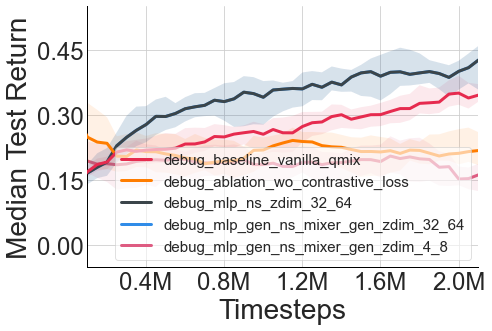

In [99]:
if 'figlegend' in config.keys():
    figure = plt.figure(figsize=(config['figlegend'], 4.8))
else:
    figure = plt.figure(figsize=(7, 4.8))
plt.style.use('seaborn-whitegrid')
plt.clf()
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')

plt.xlim(config['xlim'])
#plt.xlim(-40000, 2100000)
plt.ylim(config['ylim'])
plt.tick_params('x', labelsize=24.0)
plt.tick_params('y', labelsize=24.0)
plt.xlabel(config['xlabel'], {'size': 28.0})
plt.ylabel(config['ylabel'], {'size': 28.0})
ax.xaxis.set_major_locator(ticker.MaxNLocator(6))
ax.yaxis.set_major_locator(ticker.MaxNLocator(6))

if config['xlabel'] == 'Epoches':
    def formatnum_epoch(x, pos):
        return int(x // (5e3))
    formatter = FuncFormatter(formatnum_epoch)
    ax.xaxis.set_major_formatter(formatter)
elif config['xlabel'] == 'Iteration '+r'$t$' and args.id[0] != 'B':
    def formatnum_epoch(x, pos):
        return int(x // (100 * 200))
    formatter = FuncFormatter(formatnum_epoch)
    ax.xaxis.set_major_formatter(formatter)
elif config['xlabel'] == 'Iterations':
    def formatnum_epoch(x, pos):
        return int(x // 200)
    formatter = FuncFormatter(formatnum_epoch)
    ax.xaxis.set_major_formatter(formatter)
elif config['ylabel'] == 'Median Test Return':
    def formatnum(x, pos):
        return str(x / 1e6) + 'M'
    formatter = FuncFormatter(formatnum)
    ax.xaxis.set_major_formatter(formatter)
elif config['xlim'][1] > 1e5:
    def formatnum(x, pos):
        return str(x / 1e6) + 'M'  # '$%.1f$M' % (x / 1e6)
    formatter = FuncFormatter(formatnum)
    ax.xaxis.set_major_formatter(formatter)

if config['ylim'][1] > 1e5:
    plt.yscale('log')

id_cnt = len(list(config['color'].keys()))
for id, line_id in enumerate(list(config['order'].keys())):
    data, length, index = read_data(args, run_key=line_id)
    data = np.minimum(data, 10e30)
    data_median = np.median(data, axis=0) * config['data_scale']
    data_sort = np.sort(data, axis=0) * config['data_scale']

    num_seed = data.shape[0]
    num_get_min = int(num_seed * config['get_min_ratio'])
    num_get_max = -num_get_min - 1
    data_min = data_sort[num_get_min, :]
    data_max = data_sort[num_get_max, :]

    data_median = smooth_single(data_median, config['smooth_range'])
    data_min = smooth_single(data_min, config['smooth_range'])
    data_max = smooth_single(data_max, config['smooth_range'])
    ax.fill_between(index[: len(data[0])], data_min, data_max, alpha=0.1, color=config['color'][line_id],
                    linewidth=0)
    ax.plot(index[: len(data[0])], data_median, color=config['color'][line_id],
                label=config['legend_prefix'] + line_id, linewidth=config['linewidth'], zorder=-id + id_cnt - 1,
                linestyle=config['linestyle'][line_id])
        

if 'constant_value' in config.keys():
    if not (config['constant_value'] is None):
        ax.plot(list(config['xlim']), [config['constant_value']] * 2, color=config['constant_color'], linewidth=3,
                linestyle="dashed", label=config['constant_label'], zorder=id_cnt - 1)


if 'figlegend' in config.keys():
    plt.figlegend(loc='upper right', prop={'size': 26.0}, frameon=True, ncol=1)
    plt.tight_layout(rect=(0, 0, 6.4 / config['figlegend'], 1))
else:
    if not (config['legend_loc'] is None):
        plt.legend(loc=config['legend_loc'], prop={'size': config['legend_prop_size']}, frameon=True,
                    framealpha=config['framealpha'], facecolor='white', ncol=config['legend_ncol'])

plt.show()
timing = str(time.ctime()).replace(":", "-").replace(" ", "-")[4:19]
if 'figures' not in os.listdir():
    os.mkdir('figures')
#figure.savefig('figures/' + timing + '_' + str(config['order']) + '_' +  task.split(":")[-1] + '.pdf', bbox_inches='tight')
figure.savefig('figures/' + timing + '_' +  config['env'] + '_' + args.id + '.pdf', bbox_inches='tight')
plt.close(figure)